In [3]:
"""
Classification on CIFAR10 (ResNet)
==================================

Based on pytorch example for CIFAR10
"""


import sys
from pathlib import Path 
sys.path.append(str(Path.cwd().parent.parent))
import torch.optim
from torchvision import datasets, transforms
import torch.nn.functional as F
from kymatio import Scattering2D
import matplotlib.pyplot as plt
import torch
import torch.fft
import argparse
import kymatio.datasets as scattering_datasets
from kymatio.scattering2d.core.scattering2d import scattering2d
import torch.nn as nn
from numpy.random import RandomState
import numpy as np
import pickle
import time
import mlflow
import os
from parametricSN.utils.context import get_context
from parametricSN.utils.wavelet_visualization import get_filters_visualization
from pathlib import Path
import yaml
import os
import sys


In [4]:
def construct_scattering(input, scattering, psi):
    if not torch.is_tensor(input):
        raise TypeError('The input should be a PyTorch Tensor.')

    if len(input.shape) < 2:
        raise RuntimeError('Input tensor must have at least two dimensions.')

    if not input.is_contiguous():
        raise RuntimeError('Tensor must be contiguous.')

    if (input.shape[-1] != scattering.N or input.shape[-2] != scattering.M) and not scattering.pre_pad:
        raise RuntimeError('Tensor must be of spatial size (%i,%i).' % (scattering.M, scattering.N))

    if (input.shape[-1] != scattering.N_padded or input.shape[-2] != scattering_padded) and scattering.pre_pad:
        raise RuntimeError('Padded tensor must be of spatial size (%i,%i).' % (scattering.M_padded, scattering.N_padded))

    if not scattering.out_type in ('array', 'list'):
        raise RuntimeError("The out_type must be one of 'array' or 'list'.")

    # phi, psi  = scattering.load_filters()
    # make_filters_diff(psi)
    # scattering.psi = psi

    batch_shape = input.shape[:-2]
    signal_shape = input.shape[-2:]

    input = input.reshape((-1,) + signal_shape)

    S = scattering2d(input, scattering.pad, scattering.unpad, scattering.backend, scattering.J,
                        scattering.L, scattering.phi, psi, scattering.max_order, scattering.out_type)

    if scattering.out_type == 'array':
        scattering_shape = S.shape[-3:]
        S = S.reshape(batch_shape + scattering_shape)
    # else:
    #     scattering_shape = S[0]['coef'].shape[-2:]
    #     new_shape = batch_shape + scattering_shape

    #     for x in S:
    #         x['coef'] = x['coef'].reshape(new_shape)

    return S

In [5]:
def make_filters_diff(psi):
    """ This function make the filters differentiable """
    # 
    filters = []
    for j in range(len(psi)):
        for k, v in psi[j].items():
            if not isinstance(k, int):
                continue
            v.requires_grad = True
            filters.append(v)
    return filters

In [6]:
class Identity(nn.Module):
    def __init__(self, *args, **kwargs):
        super().__init__()
    def forward(self, x):
        return x


class LinearLayer(nn.Module):
    def __init__(self, in_channels,  k=2, n=4, num_classes=10, standard=False):
        super().__init__()
        self.inplanes = 16 * k
        self.ichannels = 16 * k * 3
        if standard:
            self.fc = nn.Linear(3*32*32, num_classes)
        else:
            self.fc = nn.Linear(3*64*81, num_classes)

    def forward(self, x):
        x = x.view(x.shape[0], -1)
        return self.fc(x)




In [7]:
def train(model, device, train_loader, is_scattering_dif, optimizer, epoch, scattering, psi):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device, dtype=torch.long)
        optimizer.zero_grad()
        if is_scattering_dif:
            data = construct_scattering(data, scattering, psi)
        else:
            data = scattering(data)
        output = model(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 50 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

def test(model, device, test_loader, is_scattering_dif, scattering, psi):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device, dtype=torch.long)
            if is_scattering_dif:
                data = construct_scattering(data, scattering, psi)
            else:
                data = scattering(data)
            output = model(data)
            output = model(data)
            test_loss += F.cross_entropy(output, target, size_average=False).item() # sum up batch loss
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    return 100. * correct / len(test_loader.dataset)

In [8]:
# Get the current project path (where you open the notebook)
# and go up two levels to get the project path
current_dir = Path.cwd().parent.parent
#proj_path = current_dir.parent
proj_path = current_dir
# make the code in src available to import in this notebook
sys.path.append(os.path.join(proj_path, 'kymatio'))

#Catalog contains all the paths related to datasets
with open(os.path.join(proj_path, 'conf/data_catalog.yml'), "r") as f:
    catalog = yaml.safe_load(f)

# Params contains all of the dataset creation parameters and model parameters
with open(os.path.join(proj_path, f'conf/parameters.yml'), "r") as f:
    params = yaml.safe_load(f)

/NOBACKUP/gauthiers/kymatio_mod/kymatio/frontend/entry.py:21: DeprecationWarning: Torch frontend is currently the default, but NumPy will become the default in the next version.
  " version.", DeprecationWarning)


Files already downloaded and verified


KeyError: 'num_samples'

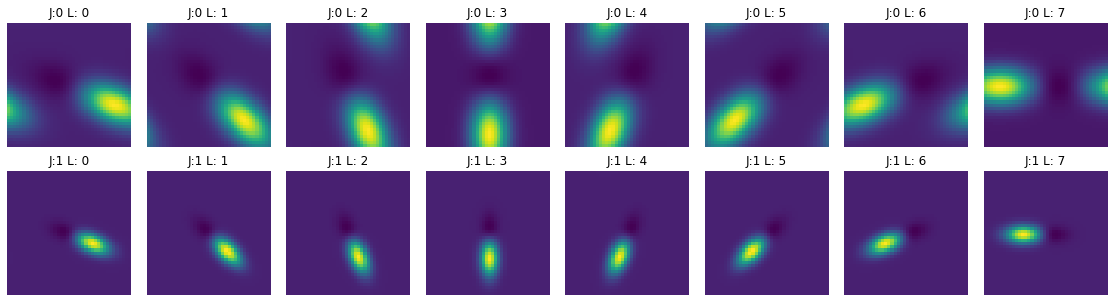

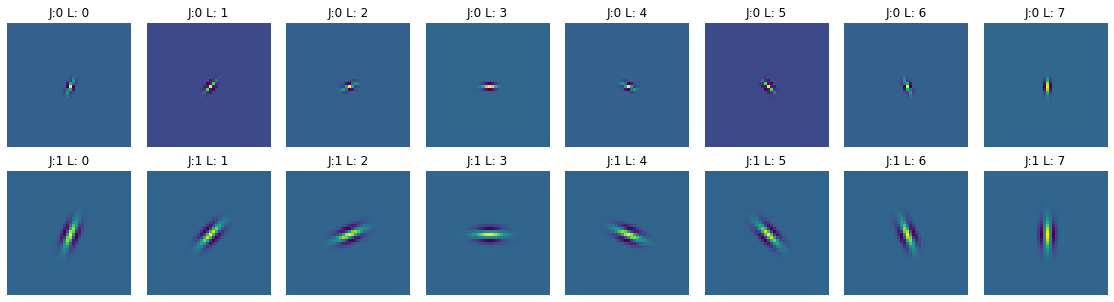

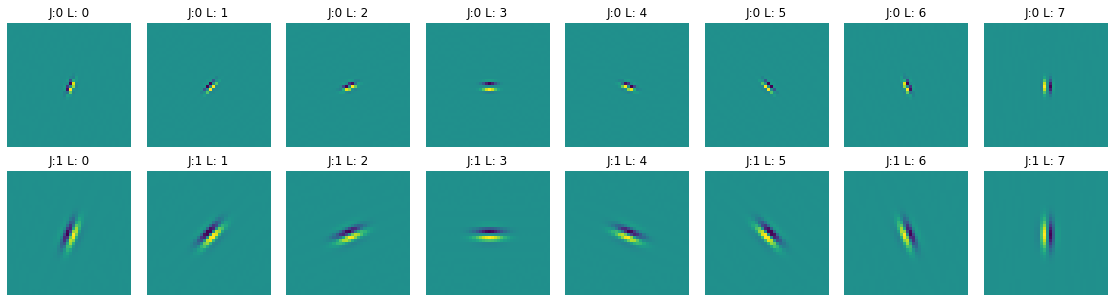

In [9]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
is_scattering_dif = False
if params['model']['mode'] == 'scattering_dif' or params['model']['mode'] == 'scattering':
    J = params['scattering']['J']
    M, N= params['preprocess']['dimension']['M'], params['preprocess']['dimension']['N']
    scattering = Scattering2D(J=J, shape=(M, N))
    K = 81*3
    model = LinearLayer(K, params['model']['width']).to(device)
    if use_cuda:
        scattering = scattering.cuda()

    phi, psi  = scattering.load_filters()
    # visualize wavlet filters before training
    filters_plots_before = {}
    for mode in ['fourier','real', 'imag' ]:
        f = get_filters_visualization(psi, num_row = 2 , num_col =8 , mode =mode)
        filters_plots_before [mode]  = f  
    if params['model']['mode'] == 'scattering_dif' :
        lr_scattering = params['model']['lr_scattering']  
        filters = make_filters_diff(psi)
        is_scattering_dif = True

else:
    model = LinearLayer(8, params['model']['width'], standard=True).to(device)
    scattering = Identity()
    psi = None
    filters_plots_before = {}


# DataLoaders
if use_cuda:
    num_workers = 4
    pin_memory = True
else:
    num_workers = 0
    pin_memory = False

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])


#####cifar data
cifar_data = datasets.CIFAR10(root=scattering_datasets.get_dataset_dir('CIFAR'), train=True, transform=transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomCrop(32, 4),
        transforms.ToTensor(),
        normalize,
    ]), download=True)
# Extract a subset of X samples per class
prng = RandomState(params['model']['seed'])
random_permute = prng.permutation(np.arange(0, 5000))[0:params['model']['num_samples']]
indx = np.concatenate([np.where(np.array(cifar_data.targets) == classe)[0][random_permute] for classe in range(0, 10)])

cifar_data.data, cifar_data.targets = cifar_data.data[indx], list(np.array(cifar_data.targets)[indx])
train_loader = torch.utils.data.DataLoader(cifar_data,
                                           batch_size=64, shuffle=True, num_workers=num_workers,
                                           pin_memory=pin_memory)

test_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10(root=scattering_datasets.get_dataset_dir('CIFAR'), train=False, transform=transforms.Compose([
        transforms.ToTensor(),
        normalize,
    ])),
    batch_size=32, shuffle=False, num_workers=num_workers, pin_memory=pin_memory)



In [26]:
# Optimizer
lr = params['model']['lr']
lr_scattering = params['model']['lr_scattering']  
M = params['model']['learning_schedule_multi']
drops = [60*M,120*M,160*M]
test_acc = []
start_time = time.time()
for epoch in range(0, 15):
    #for epoch in range(0, 1):
        if epoch in drops or epoch==0:
            if is_scattering_dif:
                optimizer = torch.optim.SGD([{'params': filters, 'lr': lr_scattering}, 
                                        {'params': model.parameters()}], lr=lr, momentum=0.9,
                                        weight_decay=0.0005)
                lr_scattering*=0.2
            else:
                optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9,
                                        weight_decay=0.0005)
            lr*=0.2


        train(model, device, train_loader, is_scattering_dif, optimizer, epoch+1, scattering, psi)
        if epoch%10==0:
            test_acc.append(test(model, device, test_loader, is_scattering_dif, scattering, psi))


Train Epoch: 1 [0/500 (0%)]	Loss: 2.312511

Test set: Average loss: 2.2106, Accuracy: 2617/10000 (26.17%)

Train Epoch: 2 [0/500 (0%)]	Loss: 2.256543
Train Epoch: 3 [0/500 (0%)]	Loss: 2.524125
Train Epoch: 4 [0/500 (0%)]	Loss: 2.277010
Train Epoch: 5 [0/500 (0%)]	Loss: 2.928206
Train Epoch: 6 [0/500 (0%)]	Loss: 2.535602
Train Epoch: 7 [0/500 (0%)]	Loss: 2.378175
Train Epoch: 8 [0/500 (0%)]	Loss: 2.233347
Train Epoch: 9 [0/500 (0%)]	Loss: 2.441675
Train Epoch: 10 [0/500 (0%)]	Loss: 2.296916
Train Epoch: 11 [0/500 (0%)]	Loss: 2.404501

Test set: Average loss: 2.2858, Accuracy: 3481/10000 (34.81%)

Train Epoch: 12 [0/500 (0%)]	Loss: 1.959310
Train Epoch: 13 [0/500 (0%)]	Loss: 2.449455
Train Epoch: 14 [0/500 (0%)]	Loss: 2.575195
Train Epoch: 15 [0/500 (0%)]	Loss: 2.370441


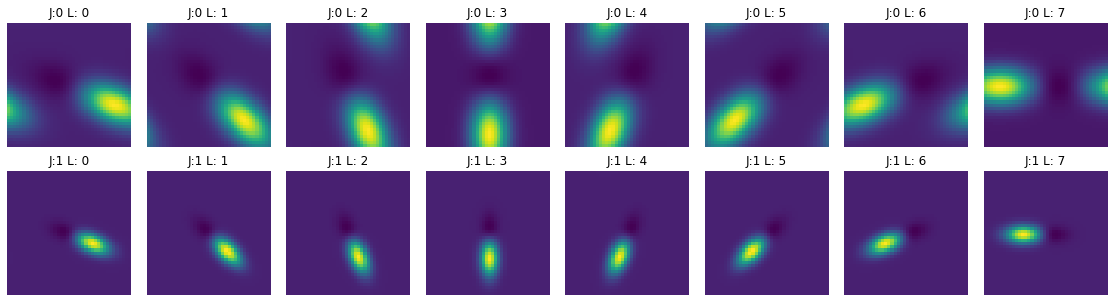

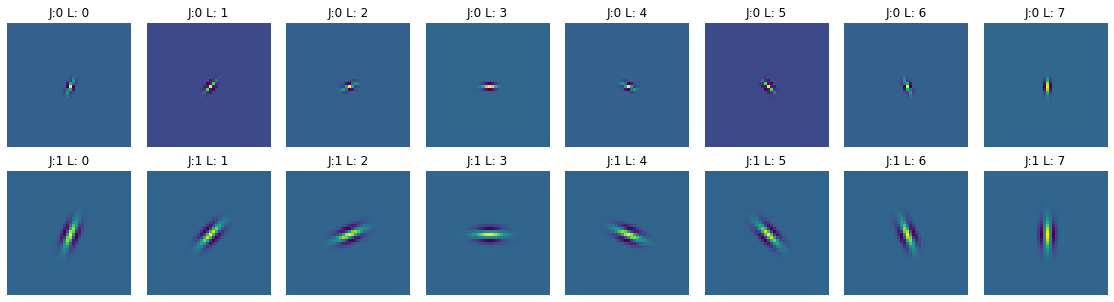

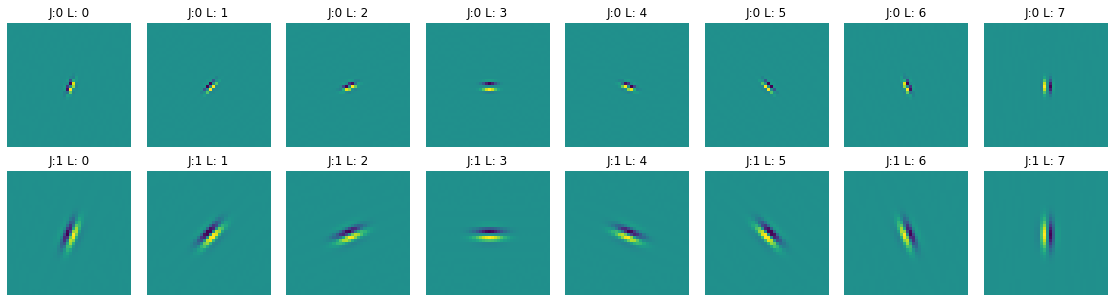

In [9]:
#visualize filters
filters_plots_after= {}
if psi is not None:
    for mode in ['fourier','real', 'imag' ]:
        f = get_filters_visualization(psi, num_row = 2 , num_col =8 , mode =mode)
        filters_plots_after[mode]  = f  

In [ ]:
gaussian_bases = torch.randn(25, 2, 2)
wave_vectors = gaussian_bases[:, 0]
norm_factors = (gaussian_bases[:, 0] * gaussian_bases[:, 1]).sum(1) / (gaussian_bases[:, 0] * gaussian_bases[:, 0]).sum(1)
gaussian_bases[:, 1] -=  norm_factors[..., np.newaxis] * gaussian_bases[:, 0]
some_morlets = raw_morlets((64, 64), wave_vectors, gaussian_bases , fft=False, ifftshift=False)



In [10]:
J=2
L=8
orientations = []
xis = []
sigmas = []
slants = []

for j in range(J):
    for theta in range(L):
        sigmas.append(0.8 * 2**j)
        theta = ((int(L-L/2-1)-theta) * np.pi / L)
        xis.append(3.0 / 4.0 * np.pi /2**j)
        slants.append(4.0/L)
        orientations.append(np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]], np.float32))
        #R_inv = np.array([[np.cos(theta), np.sin(theta)], [-np.sin(theta), np.cos(theta)]], np.float32)
        
       
xis = torch.FloatTensor(xis)
sigmas = torch.FloatTensor(sigmas)
slants = torch.FloatTensor(slants)
orientations = torch.FloatTensor(orientations)   
#wavelets = morlets((40, 40), orientations[:, 0], xis, sigmas, slants)

In [39]:
scattering = Scattering2D(J=3, shape=(M, N))

/NOBACKUP/gauthiers/kymatio_mod/kymatio/frontend/entry.py:21: DeprecationWarning: Torch frontend is currently the default, but NumPy will become the default in the next version.
  " version.", DeprecationWarning)


In [40]:
phi, psi  = scattering.load_filters()

In [61]:
type(psi)


list

In [48]:
psi[23][0].shape

torch.Size([48, 48, 1])

/NOBACKUP/gauthiers/kymatio_mod/kymatio/frontend/entry.py:21: DeprecationWarning: Torch frontend is currently the default, but NumPy will become the default in the next version.
  " version.", DeprecationWarning)


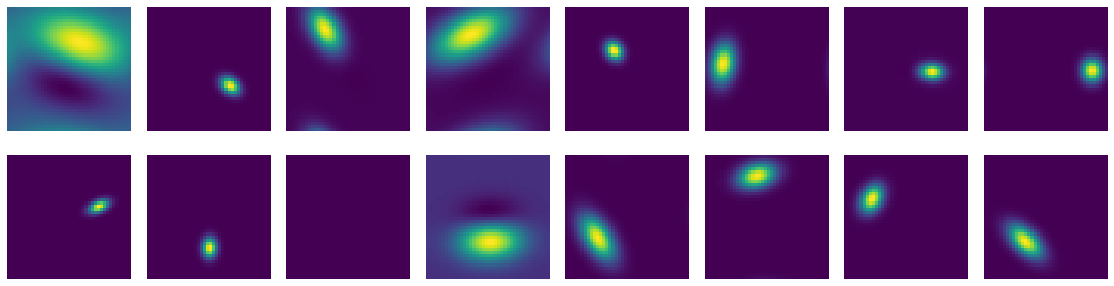

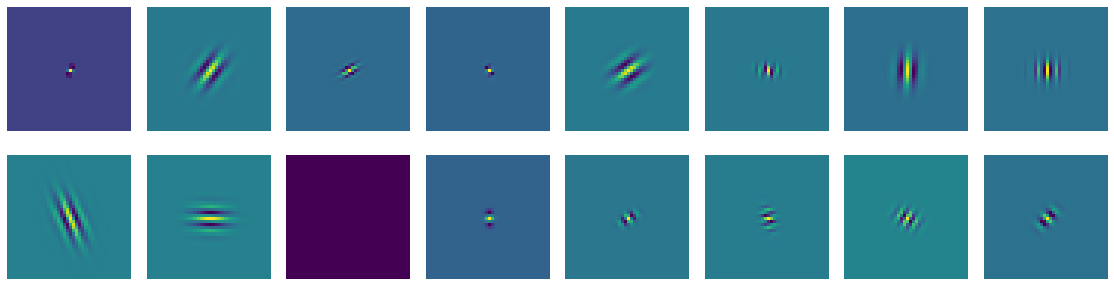

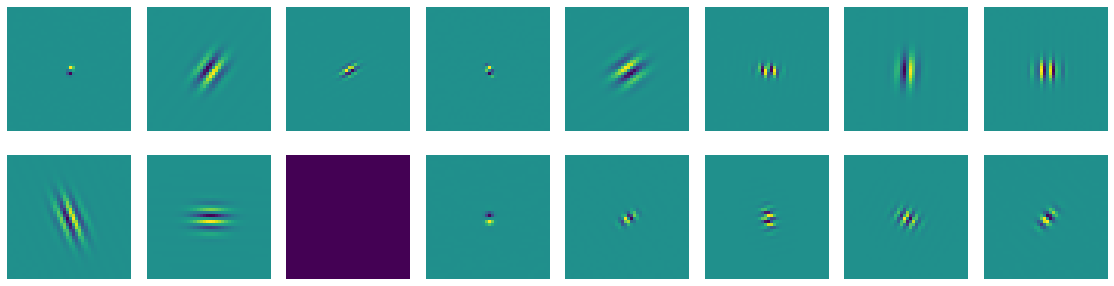

In [20]:

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
is_scattering_dif = False
if params['model']['mode'] == 'scattering_dif' or params['model']['mode'] == 'scattering':
    J = params['scattering']['J']
    M, N= params['preprocess']['dimension']['M'], params['preprocess']['dimension']['N']
    scattering = Scattering2D(J=J, shape=(M, N))
    K = 81*3
    model = LinearLayer(K, params['model']['width']).to(device)
    if use_cuda:
        scattering = scattering.cuda()

    orientations, xis, sigmas, slants = create_filters_params(J, scattering.L, 2)
    psi = wavelets = morlets((scattering.M_padded, scattering.N_padded,), orientations, xis, sigmas, slants)
    # visualize wavlet filters before training
    filters_plots_before = {}
    for mode in ['fourier','real', 'imag' ]:
        f = get_filters_visualization(psi, num_row = 2 , num_col =8 , mode =mode)
        filters_plots_before [mode]  = f  
    if params['model']['mode'] == 'scattering_dif' :
        lr_scattering = params['model']['lr_scattering']  
        #filters = make_filters_diff(psi)
        is_scattering_dif = True

In [294]:
def create_filters_params(J, L):
    '''
        Create reusable filters parameters: orientations, xis, sigmas, sigmas
    '''
    orientations = []
    xis = []
    sigmas = []
    slants = []

    for j in range(J):
        for theta in range(L):
            sigma = 0.8 * 2**j
            sigmas.append(0.8 * 2**j)
            theta = ((int(L-L/2-1)-theta) * np.pi / L)
            xis.append(3.0 / 4.0 * np.pi /2**j)
            slant = 4.0/L
            slants.append(slant)
            
            #orientations.append(np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]], np.float32))
            #R = np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]], np.float32)
            D = np.array([[1, 0], [0, slant * slant]])
            R_inv = np.array([[np.cos(theta), np.sin(theta)], [-np.sin(theta), np.cos(theta)]], np.float32)
            #orientations.append( (np.dot(R, np.dot(D, R_inv)) / ( 2 * sigma * sigma)))
            orientations.append(R_inv)
             
    xis = torch.FloatTensor(xis)
    sigmas = torch.FloatTensor(sigmas)
    slants = torch.FloatTensor(slants)
    orientations = torch.FloatTensor(orientations)   
    return orientations[:, 0], xis, sigmas, slants

In [ ]:
def create_filters_params(J, L, is_scattering_dif, ndim):
    n_filters = J*L
    sigmas = np.log(np.random.uniform(np.exp(0), np.exp(3), n_filters ))
    # For the orientation, choose uniform on the circle 
    #(can init some 2d gaussian values then divide by their norm 
    # or take complex exponential/ cos & sin of uniform between 0 and 2pi).
    orientations = np.random.normal(0,1,(n_filters,ndim)) 
    norm = np.linalg.norm(orientations, axis=1).reshape(orientations.shape[0], 1)
    orientations = orientations/norm
    slants = np.random.uniform(0.5, 1.5,n_filters )# like uniform between 0.5 and 1.5.
    xis = np.random.uniform(1, 2, n_filters )
    
    xis = torch.FloatTensor(xis)
    sigmas = torch.FloatTensor(sigmas)
    slants = torch.FloatTensor(slants)
    orientations = torch.FloatTensor(orientations) 
    params = [orientations, xis, sigmas, slants]
    if is_scattering_dif:
        for param in params:
            param.requires_grad = True
    return  params

In [10]:
def morlets(grid_or_shape, orientations, xis, sigmas, slants, device=None, morlet=True, ifftshift=True, fft=True):
    n_filters, ndim = orientations.shape
    if device is None:
        device = orientations.device
    orientations = orientations / (torch.norm(orientations, dim=1, keepdim=True) + 1e-19)
    wave_vectors = orientations * xis[:, np.newaxis]
    _, _, gauss_directions = torch.linalg.svd(orientations[:, np.newaxis])
    gauss_directions = gauss_directions / sigmas[:, np.newaxis, np.newaxis]
    indicator = torch.arange(ndim) < 1
    slant_modifications = (1.0 * indicator + slants[:, np.newaxis] * ~indicator).to(gauss_directions.device)
    gauss_directions = gauss_directions * slant_modifications[:, :, np.newaxis]
    wavelets = raw_morlets(grid_or_shape, wave_vectors, gauss_directions, morlet=morlet, 
                          ifftshift=ifftshift, fft=fft)
    
    norm_factors = (2 * 3.1415 * sigmas * sigmas / slants).unsqueeze(1)
    norm_factors = norm_factors.expand([n_filters,grid_or_shape[0]]).unsqueeze(2).repeat(1,1,grid_or_shape[1])
    wavelets = wavelets / norm_factors
    return wavelets

In [11]:
def raw_morlets(grid_or_shape, wave_vectors, gaussian_bases, morlet=True, ifftshift=True, fft=True):
    n_filters, n_dim = wave_vectors.shape
    assert gaussian_bases.shape == (n_filters, n_dim, n_dim)
    device = wave_vectors.device
    if isinstance(grid_or_shape, tuple):
        shape = grid_or_shape
        ranges = [torch.arange(-(s // 2), -(s // 2) + s, device=device, dtype=torch.float) for s in shape]
        grid = torch.stack(torch.meshgrid(*ranges), 0)
    else:
        shape = grid_or_shape.shape
        grid = grid
        _or_shape
    waves = torch.exp(1.0j * torch.matmul(grid.T, wave_vectors.T).T)
    gaussian_directions = torch.matmul(grid.T, gaussian_bases.T.reshape(n_dim, n_dim * n_filters)).T
    gaussian_directions = gaussian_directions.reshape((n_dim, n_filters) + shape)
    radii = torch.norm(gaussian_directions, dim=0)
    gaussians = torch.exp(-0.5 * radii ** 2)
    signal_dims = list(range(1, n_dim + 1))
    gabors = gaussians * waves
    gabors = gabors
    if morlet:
        gaussian_sums = gaussians.sum(dim=signal_dims, keepdim=True)
        gabor_sums = gabors.sum(dim=signal_dims, keepdim=True).real
        morlets = gabors - gabor_sums / gaussian_sums * gaussians
        filters = morlets
    else:
        filters = gabors
    if ifftshift:
        filters = torch.fft.ifftshift(filters, dim=signal_dims)
    if fft:
        filters = torch.fft.fftn(filters, dim=signal_dims)
    return filters

In [426]:
def create_filters_params_random(n_filters , is_scattering_dif, ndim, seed=0):
    #n_filters = J*L
    np.random.seed(seed)
    sigmas = np.log(np.random.uniform(np.exp(0), np.exp(3), n_filters ))
    # For the orientation, choose uniform on the circle 
    #(can init some 2d gaussian values then divide by their norm 
    # or take complex exponential/ cos & sin of uniform between 0 and 2pi).
    orientations = np.random.normal(0,1,(n_filters,ndim)) 
    norm = np.linalg.norm(orientations, axis=1).reshape(orientations.shape[0], 1)
    orientations = orientations/norm
    slants = np.random.uniform(0.5, 1.5,n_filters )# like uniform between 0.5 and 1.5.
    xis = np.random.uniform(1, 2, n_filters )
    
    xis = torch.FloatTensor(xis)
    sigmas = torch.FloatTensor(sigmas)
    slants = torch.FloatTensor(slants)
    orientations = torch.FloatTensor(orientations) 
    params = [orientations, xis, sigmas, slants]

    if is_scattering_dif:
        for param in params:
            param.requires_grad = True
    return  params


In [252]:
def create_filters_params(J, L):
    '''
        Create reusable filters parameters: orientations, xis, sigmas, sigmas
    '''
    orientations = []
    xis = []
    sigmas = []
    slants = []

    for j in range(J):
        for theta in range(L):
            sigma = 0.8 * 2**j
            sigmas.append(0.8 * 2**j)
            theta = ((int(L-L/2-1)-theta) * np.pi / L)
            xis.append(3.0 / 4.0 * np.pi /2**j)
            slant = 4.0/L
            slants.append(slant)
            
            #orientations.append(np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]], np.float32))
            #R = np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]], np.float32)
            D = np.array([[1, 0], [0, slant * slant]])
            R_inv = np.array([[np.cos(theta), np.sin(theta)], [-np.sin(theta), np.cos(theta)]], np.float32)
            #orientations.append( (np.dot(R, np.dot(D, R_inv)) / ( 2 * sigma * sigma)))
            orientations.append(R_inv)
             
    xis = torch.FloatTensor(xis)
    sigmas = torch.FloatTensor(sigmas)
    slants = torch.FloatTensor(slants)
    orientations = torch.FloatTensor(orientations)   
    return orientations[:, 0], xis, sigmas, slants

24

In [342]:
wavelets = morlets((40, 40), orientations, xis, sigmas, slants, morlet=True, ifftshift=True, fft=True)

In [471]:
def periodize_filter_fft(x, res, device):
    """
        Parameters
        ----------
        x : numpy array
            signal to periodize in Fourier
        res :
            resolution to which the signal is cropped.

        Returns
        -------
        crop : torch array
            It returns a crop version of the filter, assuming that
             the convolutions will be done via compactly supported signals.
    """

    M = x.shape[0]
    N = x.shape[1]
    crop = torch.zeros((M // 2 ** res, N // 2 ** res), dtype = x.dtype).to(device)

    mask = torch.ones(x.shape, dtype =torch.float32).to(device)
    len_x = int(M * (1 - 2 ** (-res)))
    start_x = int(M * 2 ** (-res - 1))
    len_y = int(N * (1 - 2 ** (-res)))
    start_y = int(N * 2 ** (-res - 1))
    mask[start_x:start_x + len_x,:] = 0
    mask[:, start_y:start_y + len_y] = 0
    x = x*mask

    for k in range(int(M / 2 ** res)):
        for l in range(int(N / 2 ** res)):
            for i in range(int(2 ** res)):
                for j in range(int(2 ** res)):
                    crop[k, l] += x[k + i * int(M / 2 ** res), l + j * int(N / 2 ** res)]

    return crop

In [449]:
J = 4
L =8
scattering = Scattering2D(J=J, shape=(M, N), max_order =2)
phi, psi = scattering.load_filters()

/NOBACKUP/gauthiers/kymatio_mod/kymatio/frontend/entry.py:21: DeprecationWarning: Torch frontend is currently the default, but NumPy will become the default in the next version.
  " version.", DeprecationWarning)


In [455]:
psi[8][0].shape

torch.Size([64, 64, 1])

In [452]:
psi[16][1].shape

torch.Size([32, 32, 1])

In [453]:
psi[16][2].shape

torch.Size([16, 16, 1])

In [460]:
psi[8][0].shape

torch.Size([32, 32])

In [456]:
orientations, xis, sigmas, slants = create_filters_params_random(J*L , False, 2, seed=0)

In [464]:
wavelets = morlets((scattering.M_padded, scattering.N_padded), orientations, xis, sigmas, slants, morlet=True, ifftshift=True, fft=True)

In [475]:
periodize_filter_fft(wavelets[0].real.contiguous().to(device) , 2, device).shape

torch.Size([16, 16])

In [459]:
for i,d in enumerate(psi):
    for res in range(0, J-2):
        if res ==0:
             d[res]= wavelets[i].unsqueeze(2).real.contiguous().to(device) 
        elif res in d.keys():
            d[res]= periodize_filter_fft(wavelets[i].real.contiguous().to(device) , res, device)

In [439]:
n_filters =0
for j in range(2, J+1):
    n_filters+=  j* L

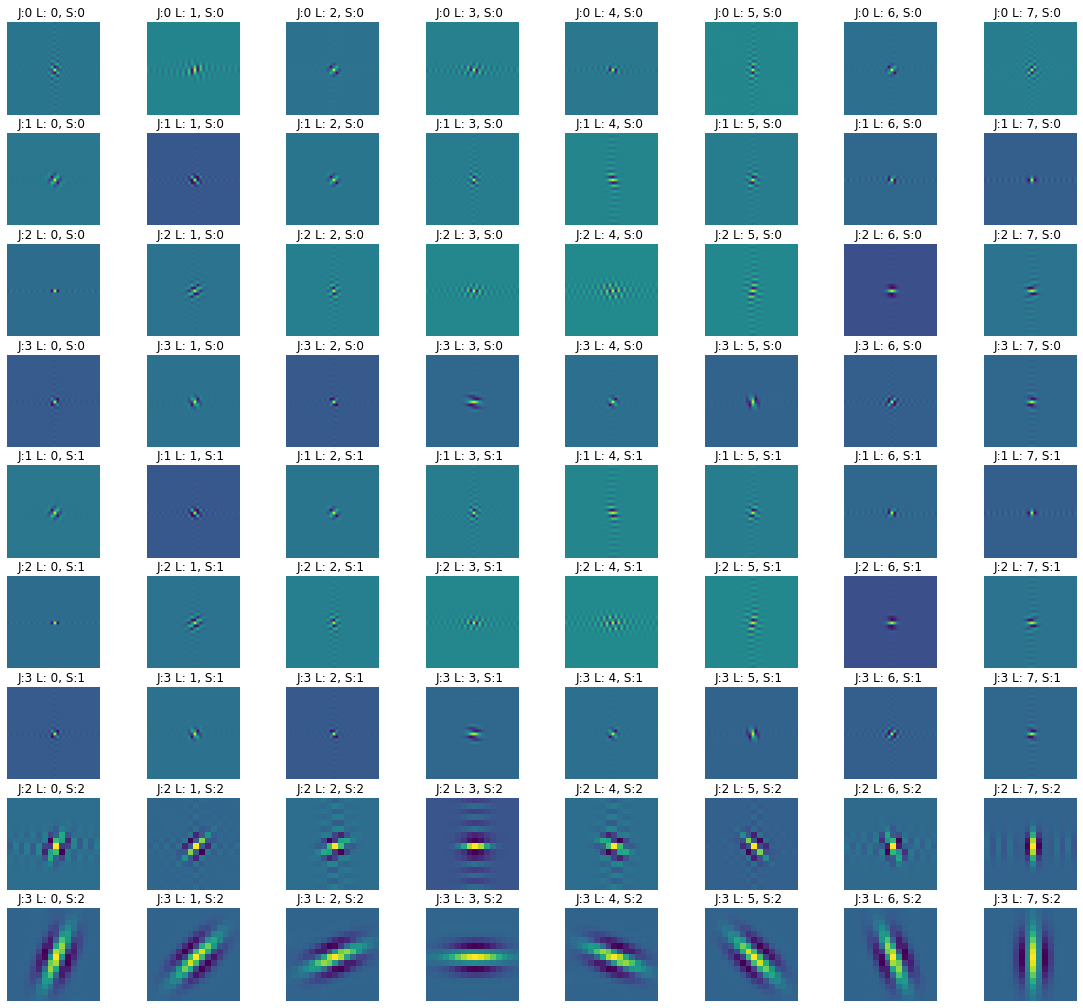

In [441]:
get_filters_visualization(psi, J, L, n_filters, 'real')

In [292]:
def get_filters_visualization(psi, J,L, n_filters, mode ='fourier'):
    '''
        Function that logs the metrics on MLFLOW
        Params: 
        filters: psi filters
        num_row: number of rows in the visualization
        num_col: number of columns in the visualization
        mode: fourier, real or imag
    '''
    num_rows = int(n_filters/L) 
    num_col = L
    f, axarr = plt.subplots(num_rows, num_col, figsize=(20, 2*num_rows))
    start_row = 0
    for scale in range(J-1):
        count = L * scale
        end_row = (J-scale) + start_row 
        for i in range(start_row, end_row) :
            for j in range(0, L) :
                if mode =='fourier':
                    x =np.fft.fftshift(psi[count][scale].squeeze().cpu().detach().numpy()).real
                elif mode == 'real':
                    x= np.fft.fftshift(np.fft.ifft2(psi[count][scale].squeeze().cpu().detach().numpy())).real
                elif mode == 'imag':
                    x= np.fft.fftshift(np.fft.ifft2(psi[count][scale].squeeze().cpu().detach().numpy())).imag
                else:
                    raise NotImplemented(f"Model {params['name']} not implemented")
                
                axarr[i,j].imshow(x)
                axarr[i,j].set_title(f"J:{psi[count]['j']} L: {psi[count]['theta']}, S:{scale} ")
                axarr[i,j].axis('off')
                count = count +1
                axarr[i,j].set_xticklabels([])
                axarr[i,j].set_yticklabels([])
                axarr[i,j].set_aspect('equal')
        start_row = end_row

    f.subplots_adjust(wspace=0, hspace=0.2)
    #return f

In [442]:
for i,d in enumerate(psi):
        d[0]=wavelets[i].unsqueeze(2).real.contiguous().to(device) 

In [448]:
psi[0][0].shape

torch.Size([64, 64, 1])

In [166]:
n_filters = 0
L= 8
J=3
for j in range(2, J+1):
    n_filters+=  j* L
    
n_filters  

40

In [289]:
L = 8
J=5
count = 0
for j in range(J):
    for theta in range(L):
        for res in range(min(j + 1, max(J - 1, 1))):
            count +=1
            print(j, theta, res, count)
            

0 0 0 1
0 1 0 2
0 2 0 3
0 3 0 4
0 4 0 5
0 5 0 6
0 6 0 7
0 7 0 8
1 0 0 9
1 0 1 10
1 1 0 11
1 1 1 12
1 2 0 13
1 2 1 14
1 3 0 15
1 3 1 16
1 4 0 17
1 4 1 18
1 5 0 19
1 5 1 20
1 6 0 21
1 6 1 22
1 7 0 23
1 7 1 24
2 0 0 25
2 0 1 26
2 0 2 27
2 1 0 28
2 1 1 29
2 1 2 30
2 2 0 31
2 2 1 32
2 2 2 33
2 3 0 34
2 3 1 35
2 3 2 36
2 4 0 37
2 4 1 38
2 4 2 39
2 5 0 40
2 5 1 41
2 5 2 42
2 6 0 43
2 6 1 44
2 6 2 45
2 7 0 46
2 7 1 47
2 7 2 48
3 0 0 49
3 0 1 50
3 0 2 51
3 0 3 52
3 1 0 53
3 1 1 54
3 1 2 55
3 1 3 56
3 2 0 57
3 2 1 58
3 2 2 59
3 2 3 60
3 3 0 61
3 3 1 62
3 3 2 63
3 3 3 64
3 4 0 65
3 4 1 66
3 4 2 67
3 4 3 68
3 5 0 69
3 5 1 70
3 5 2 71
3 5 3 72
3 6 0 73
3 6 1 74
3 6 2 75
3 6 3 76
3 7 0 77
3 7 1 78
3 7 2 79
3 7 3 80
4 0 0 81
4 0 1 82
4 0 2 83
4 0 3 84
4 1 0 85
4 1 1 86
4 1 2 87
4 1 3 88
4 2 0 89
4 2 1 90
4 2 2 91
4 2 3 92
4 3 0 93
4 3 1 94
4 3 2 95
4 3 3 96
4 4 0 97
4 4 1 98
4 4 2 99
4 4 3 100
4 5 0 101
4 5 1 102
4 5 2 103
4 5 3 104
4 6 0 105
4 6 1 106
4 6 2 107
4 6 3 108
4 7 0 109
4 7 1 110
4 7 2 11

In [30]:
psi[].keys()

dict_keys(['j', 'theta', 0])

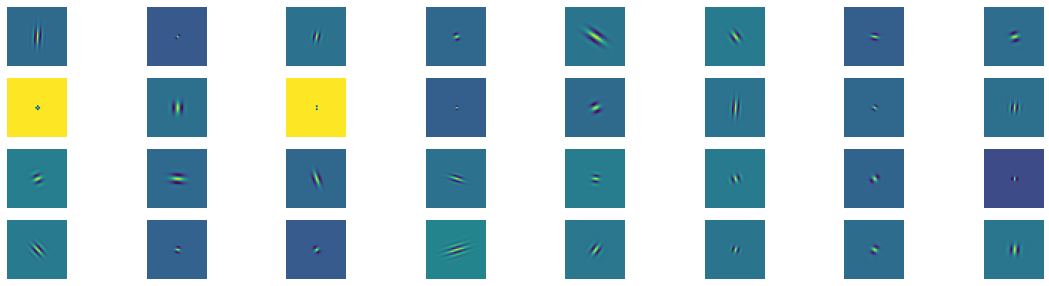

In [18]:
wavelets = morlets((40, 40), orientations, xis, sigmas, slants, morlet=True, ifftshift=True, fft=True)
f = get_filters_visualization(wavelets.unsqueeze(2).real.contiguous(), num_row = 4 , num_col =8 , mode ='real')

In [ ]:
psi

In [235]:
orientations[3] =torch.tensor([0.4531, 0.2])

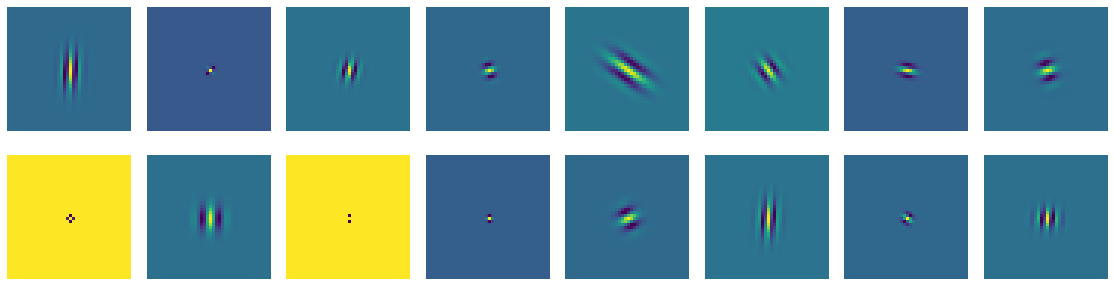

In [19]:

wavelets = morlets((40, 40), orientations, xis, sigmas, slants, morlet=True, ifftshift=True, fft=True)
f = get_filters_visualization(wavelets.unsqueeze(2).real.contiguous(), num_row = 2 , num_col =8 , mode ='real')

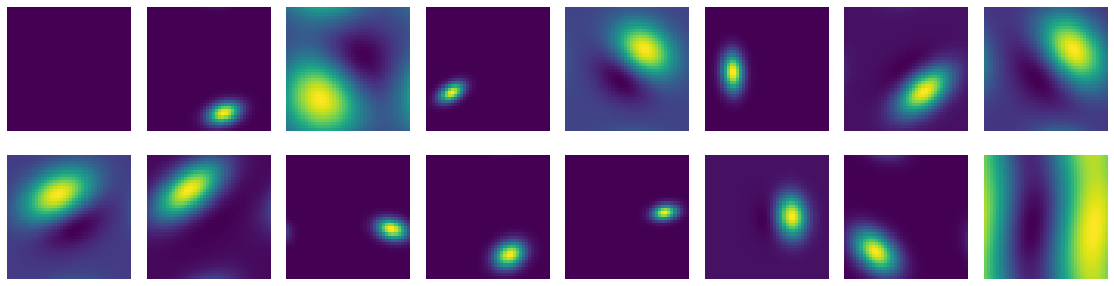

In [170]:
f = get_filters_visualization(wavelets.unsqueeze(2).real.contiguous(), num_row = 2 , num_col =8 , mode ='fourier')

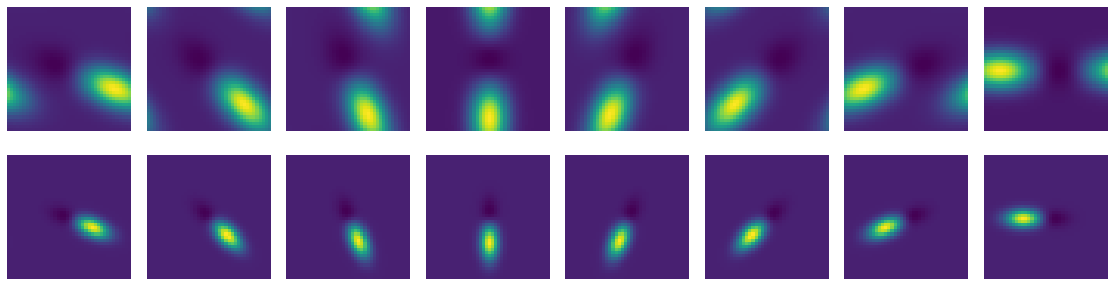

In [21]:
f = get_filters_visualization(filters, num_row = 2 , num_col =8 , mode ='fourier')

In [17]:
def get_filters_visualization(psi, num_row = 2 , num_col =8 , mode ='fourier'):
    '''
        Function that logs the metrics on MLFLOW
        Params: 
        filters: psi filters
        num_row: number of rows in the visualization
        num_col: number of columns in the visualization
        mode: fourier, real or imag
    '''
    f, axarr = plt.subplots(num_row,num_col, figsize=(20, 5))
    count = 0
    for i in range(0, num_row) :
        for j in range(0, num_col) :
            if mode =='fourier':
                x =np.fft.fftshift(psi[count].squeeze().cpu().detach().numpy()).real
            elif mode == 'real':
                x= np.fft.fftshift(np.fft.ifft2(psi[count].squeeze().cpu().detach().numpy())).real
            elif mode == 'imag':
                x= np.fft.fftshift(np.fft.ifft2(psi[count].squeeze().cpu().detach().numpy())).imag
            else:
                raise NotImplemented(f"Model {params['name']} not implemented")
            axarr[i,j].imshow(x)
            #axarr[i,j].set_title(f"J:{psi[count]['j']} L: {psi[count]['theta']}")
            axarr[i,j].axis('off')
            count = count +1
            axarr[i,j].set_xticklabels([])
            axarr[i,j].set_yticklabels([])
            axarr[i,j].set_aspect('equal')

    f.subplots_adjust(wspace=0, hspace=0.2)
    return f

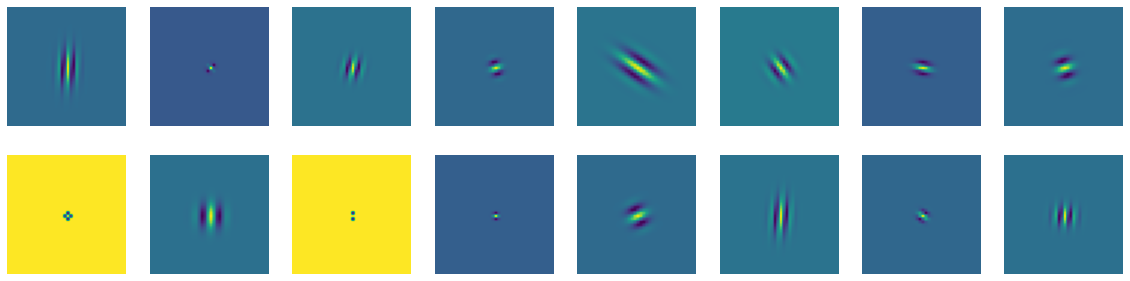

In [15]:
f, axarr = plt.subplots(2,8, figsize=(20, 5))
count = 0
for i in range(0, 2) :
    for j in range(0, 8) :
        x= np.fft.fftshift(np.fft.ifft2(wavelets[count].squeeze().cpu().detach().numpy())).real
        axarr[i,j].imshow(x)
        #axarr[i,j].set_title(f"J:{psi[count]['j']} L: {psi[count]['theta']}")
        axarr[i,j].axis('off')
        count = count +1